In [1]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [7]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo
from torchvision              import datasets
import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


In [33]:
oTransforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

In [34]:
DATA_PATH           = "/home/ubadmin/Lectures/OrYair/Datasets/PetImages/"
oDataSet            = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=oTransforms)
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

In [39]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [41]:
images, labels = next(iter(oTrainDL))
images.shape

torch.Size([128, 3, 224, 224])

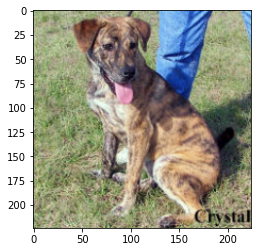

In [42]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))

In [44]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False),           nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
#         nn.Conv2d(16,  32,  3, bias=False),           nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
#         nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),
#         nn.Conv2d(64,  128, 3, bias=False),           nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
#         nn.Conv2d(128, 256, 3, bias=False, stride=2), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
#         nn.Conv2d(256, 512, 3, bias=False),           nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.1),
        
#         nn.AdaptiveAvgPool2d(1),
#         nn.Flatten          (),
#         nn.Linear           (512, 256),
#         nn.Linear           (256, 128),
#         nn.Linear           (128, 10),
    )
    
    return oModel

torchinfo.summary(GetModel(), (batchSize, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 16, 222, 222]       --
├─Identity: 1-1                          [128, 3, 224, 224]        --
├─Conv2d: 1-2                            [128, 16, 222, 222]       432
├─BatchNorm2d: 1-3                       [128, 16, 222, 222]       32
├─ReLU: 1-4                              [128, 16, 222, 222]       --
├─Dropout2d: 1-5                         [128, 16, 222, 222]       --
Total params: 464
Trainable params: 464
Non-trainable params: 0
Total mult-adds (G): 2.73
Input size (MB): 77.07
Forward/backward pass size (MB): 1614.94
Params size (MB): 0.00
Estimated Total Size (MB): 1692.01

In [45]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [46]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [47]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

In [48]:
nEpochs    = 30
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
Metric     = Accuracy
oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='CNN-1')

NameError: name 'DEVICE' is not defined